# Neural Network Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Setup

First, read the CSV data.

In [2]:
data = pd.read_csv("stars.csv")

data

,#,Name,Class,Type,Abs. Mag.,T eff.,logT,Y-Type
0,1,The Sun,G,Main Sequence,4.830,5778,3.762,1
1,2,10 Lacertae,O,Main Sequence,-4.170,34550,4.538,1
2,3,Alkaid,B,Main Sequence,-0.670,15540,4.191,1
3,4,Sirius A,A,Main Sequence,1.430,9845,3.993,1
4,5,Sirius B,NaN,White Dwarf,11.180,25000,4.398,2
5,6,Van Maanen 2,NaN,White Dwarf,14.210,6130,3.787,2
6,7,WD 0343+247,NaN,White Dwarf,16.800,4197,3.623,2
7,8,Alnitak Aa,O,Blue Supergiant,-6.000,29500,4.470,3
8,9,Aldebaran,K,Red Giant (Branch),-6.041,3900,3.591,3
9,10,Antares,M,Red supergiant,-5.280,3660,3.563,3


Let's plot this data on a simple HR diagram

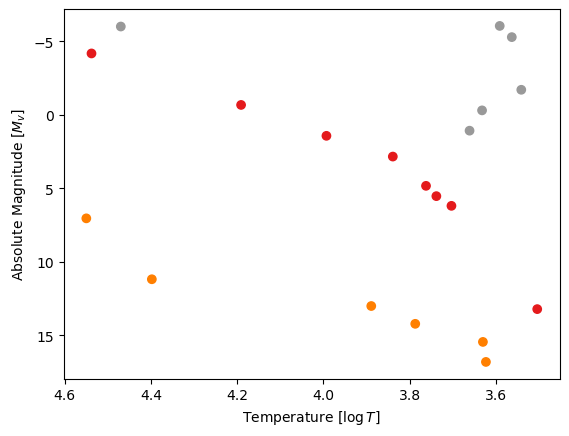

In [19]:
splot = plt.scatter(data['logT'].to_numpy(), data['Abs. Mag.'].to_numpy(), c=data['Y-Type'].to_numpy(), cmap="Set1")
plt.xlabel("Temperature [$\log T$]")
plt.ylabel("Absolute Magnitude [$M_v$]")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

Next, split the CSV data, and put it into the desired formatable array for use in training.

In [24]:
# Simple data-dependent normalisation funtion
def normalise(x): return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalise both arrays and zip together
x = np.dstack((normalise(data['Abs. Mag.'].to_numpy()), normalise(data['logT'].to_numpy())))
x

array([[[0.47594238, 0.24665392],
        [0.0819141 , 0.98852772],
        [0.23514732, 0.65678776],
        [0.32708726, 0.46749522],
        [0.75395123, 0.85468451],
        [0.88660742, 0.27055449],
        [1.        , 0.11376673],
        [0.00179502, 0.92351816],
        [0.        , 0.083174  ],
        [0.03331728, 0.05640535],
        [0.38881835, 0.32026769],
        [0.50658903, 0.22370937],
        [0.53548444, 0.19024857],
        [0.8428265 , 0.        ],
        [0.8336325 , 0.36806883],
        [0.94045795, 0.12045889],
        [0.57269822, 1.        ],
        [0.31176393, 0.1500956 ],
        [0.19005297, 0.03537285],
        [0.25134626, 0.12237094]]])

Then define the y data.

In [ ]:
y = [data['Y-Type'].to_numpy()]